### 4.2. Dropout as Bayesian Approximation in Regression Task

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py

import pymc3 as pm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

In [2]:
f = h5py.File('data/train.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

f = h5py.File('data/test.h5', 'r')
data_test = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


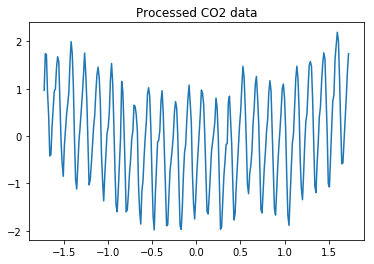

In [3]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

In [4]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024], droprate=0.1, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)
    
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024], droprate=0.1, activation='relu', \
                 max_epoch=1000000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.data[0]))
        return self
    
def predict(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor)).cuda()
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

In [5]:
mlp2 = MLP2Regressor(activation='relu').fit(X_train, y_train, verbose=False)
torch.save(mlp2.model, 'results/co2_regression_MC_relu_pytorch')

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.1)
    (hidden1): Linear(in_features=1024, out_features=1024)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.1)
    (hidden2): Linear(in_features=1024, out_features=1024)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.1)
    (hidden3): Linear(in_features=1024, out_features=1024)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.1)
    (final): Linear(in_features=1024, out_features=1)
  )
)


In [6]:
model = torch.load('results/co2_regression_MC_relu_pytorch')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_relu_pytorch_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [7]:
mlp2 = MLP2Regressor(activation='tanh').fit(X_train, y_train, verbose=False)
torch.save(mlp2.model, 'results/co2_regression_MC_tanh_pytorch')

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024)
    (tanh0): Tanh()
    (dropout1): Dropout(p=0.1)
    (hidden1): Linear(in_features=1024, out_features=1024)
    (tanh1): Tanh()
    (dropout2): Dropout(p=0.1)
    (hidden2): Linear(in_features=1024, out_features=1024)
    (tanh2): Tanh()
    (dropout3): Dropout(p=0.1)
    (hidden3): Linear(in_features=1024, out_features=1024)
    (tanh3): Tanh()
    (dropout4): Dropout(p=0.1)
    (final): Linear(in_features=1024, out_features=1)
  )
)


In [8]:
model = torch.load('results/co2_regression_MC_tanh_pytorch')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_tanh_pytorch_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [ ]:
with pm.Model() as m:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
        
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

In [ ]:
with m:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)

IO('results/co2_regression_gp.pkl').to_pickle((m, trace1))

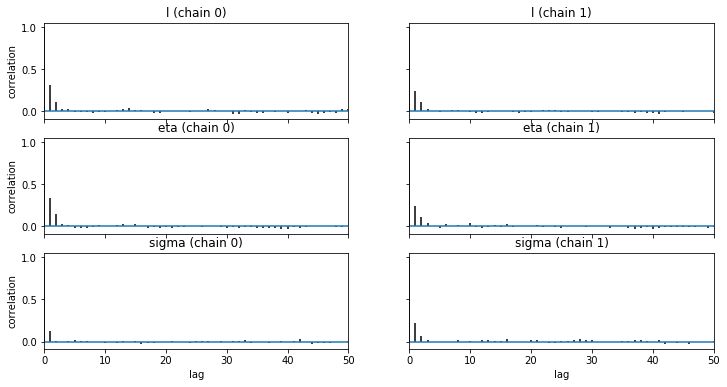

In [5]:
m, trace1 = IO('results/co2_regression_gp.pkl').read_pickle()
pm.autocorrplot(trace1, max_lag=50);

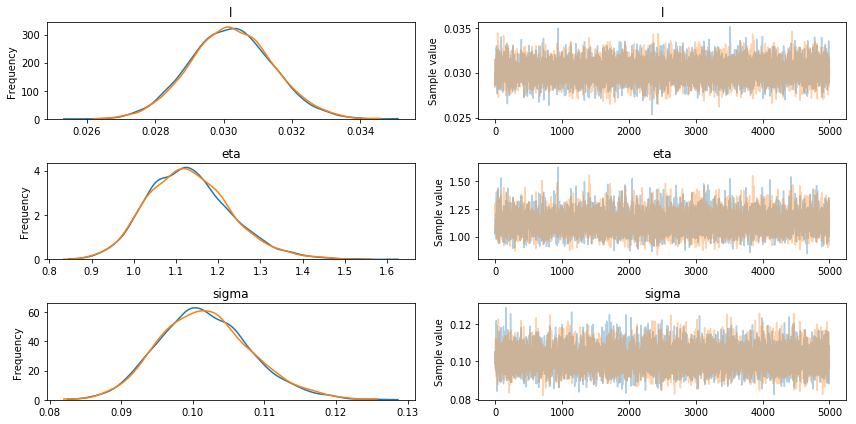

In [6]:
pm.traceplot(trace1);

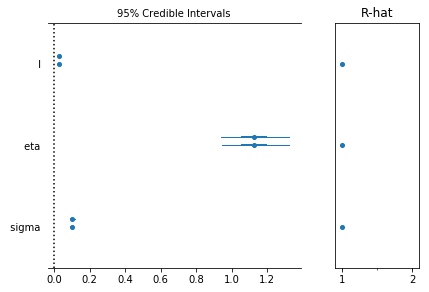

In [7]:
pm.forestplot(trace1);

In [ ]:
with m:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)
IO('results/co2_regression_gp_results.pkl').to_pickle((y_gp_pred, y_gp_std))

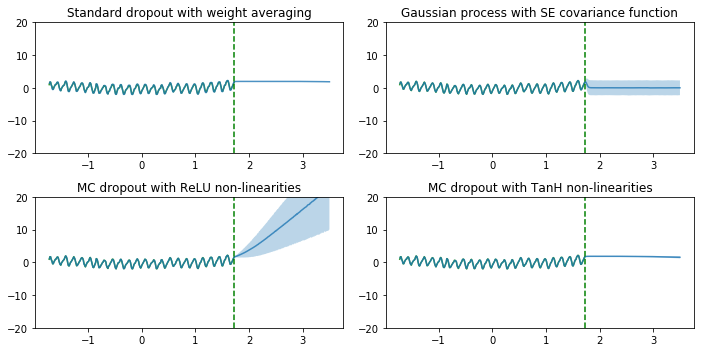

In [5]:
y_relu_pred, y_relu_mc, y_relu_mc_std = IO('results/co2_regression_MC_relu_pytorch_results.pkl').read_pickle()
y_tanh_pred, y_tanh_mc, y_tanh_mc_std = IO('results/co2_regression_MC_tanh_pytorch_results.pkl').read_pickle()
y_gp_pred, y_gp_std = IO('results/co2_regression_gp_results.pkl').read_pickle()

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();